## Confusion matrix metrics for binary classification in PyTorch

### 1. Binary Confusion Matrix Calculation

In [46]:
import torch

def get_binary_confusion_matrix(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum().item()
    TN = ((y_true == 0) & (y_pred == 0)).sum().item()
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()

    return TP, TN, FP, FN


### 2. Binary Metrics Calculation

In [47]:
def compute_binary_metrics(TP, TN, FP, FN):
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


### 3. Example Usage

In [48]:
# Example binary predictions (0 or 1)
y_true = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
y_pred = torch.tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1])

TP, TN, FP, FN = get_binary_confusion_matrix(y_true, y_pred)
metrics = compute_binary_metrics(TP, TN, FP, FN)

print("Confusion Matrix:")
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print("Metrics:", metrics)


Confusion Matrix:
TP=4, TN=4, FP=1, FN=1
Metrics: {'accuracy': 0.7999999992, 'precision': 0.7999999984, 'recall': 0.7999999984, 'f1': 0.7999999934}


### 4. Use sklearn.metrics

In [49]:
from sklearn.metrics import confusion_matrix

y_true = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[4 1]
 [1 4]]


In [50]:
from sklearn.metrics import precision_score, recall_score

y_true = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.8
Recall: 0.8


In [51]:
from sklearn.metrics import f1_score

y_true = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)


F1 Score: 0.8


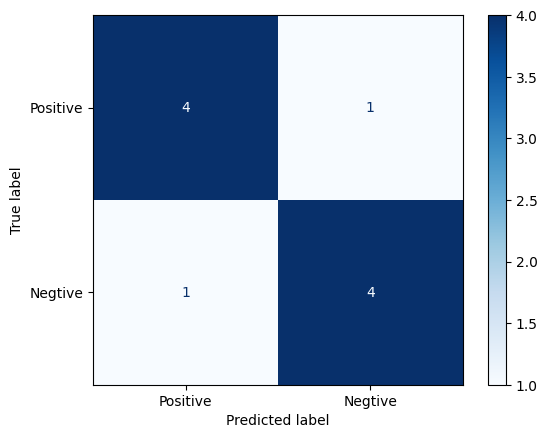

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=['Positive', 'Negtive'], cmap='Blues'
)
plt.show()


## Breast cancer with F1 scores

In [53]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_data():
    """Load and preprocess breast cancer dataset."""
    # Load dataset
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train.astype(np.float32))
    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1, 1)
    y_test = torch.from_numpy(y_test.astype(np.float32)).view(-1, 1)
    
    return X_train, X_test, y_train, y_test

class BinaryClassifier(nn.Module):
    """Simple neural network for binary classification."""
    def __init__(self, input_features):
        super(BinaryClassifier, self).__init__()
        self.linear = nn.Linear(input_features, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.01):
    """Train the model with given parameters."""
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance on test set."""
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_classes = y_pred.round()
        accuracy = y_pred_classes.eq(y_test).sum() / float(y_test.shape[0])
        return accuracy.item()

def calculate_metrics(model, X_test, y_test):
    """Calculate confusion matrix and F1 score for test set."""
    with torch.no_grad():
        # Get predictions
        y_pred = model(X_test)
        y_pred_classes = y_pred.round().squeeze()  # Convert to binary (0 or 1)
        y_true = y_test.squeeze()  # True labels
        
        # Calculate confusion matrix
        TP = torch.sum((y_pred_classes == 1) & (y_true == 1)).item()
        TN = torch.sum((y_pred_classes == 0) & (y_true == 0)).item()
        FP = torch.sum((y_pred_classes == 1) & (y_true == 0)).item()
        FN = torch.sum((y_pred_classes == 0) & (y_true == 1)).item()
        
        # Calculate precision, recall, and F1 score
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Print results
        print("\nConfusion Matrix:")
        print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        return TP, TN, FP, FN, f1

def main():
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data()
    
    # Initialize model
    n_features = X_train.shape[1]
    model = BinaryClassifier(n_features)
    
    # Train model
    print("Training model...")
    train_model(model, X_train, y_train)
    
    # Evaluate model
    accuracy = evaluate_model(model, X_test, y_test)
    print(f'\nTest Accuracy: {accuracy:.4f}')
    
    # Calculate additional metrics
    print("\nCalculating additional metrics...")
    calculate_metrics(model, X_test, y_test)

if __name__ == "__main__":
    main()

Training model...
Epoch [10/100], Loss: 0.6216
Epoch [20/100], Loss: 0.5017
Epoch [30/100], Loss: 0.4293
Epoch [40/100], Loss: 0.3805
Epoch [50/100], Loss: 0.3452
Epoch [60/100], Loss: 0.3181
Epoch [70/100], Loss: 0.2966
Epoch [80/100], Loss: 0.2789
Epoch [90/100], Loss: 0.2641
Epoch [100/100], Loss: 0.2515

Test Accuracy: 0.9035

Calculating additional metrics...

Confusion Matrix:
TP: 65, TN: 38, FP: 7, FN: 4
Precision: 0.9028
Recall: 0.9420
F1 Score: 0.9220


## Homework: replace Breast cancer conusioin matrix and F1 scores with sklean.metrcs